# Mercado Livre API - Overview da API a partir de uma query
Esse notebook apresenta diferentes métricas que se pode obter ao realizar uma query à API do Mercado Libre. 

(No momento, experimentando com diferentes visualizações. Ao finalizar uma versão, a descrição dos passos será completada de acordo).

## Como usar

1. No menu superior: `Cell > Run All`
2. Digitar busca desejada no campo de texto e pressionar *Enter*
3. Aguardar alguns instantes até execução ser completada ("(Busy)" irá desaparecer do título da aba no browser)
4. Rolar para baixo e analisar os gráficos e tabelas

Para uma nova consulta, recomeçar do item 1. 

Obs.: caso a execução apresentar erros, clicar em `Kernel > Restart & Run All` no menu superior.

## Table of contents
- Resumo em lista dos itens com maior faturamento
- Faturamento por itens
- Visualização de quantidades vendidas, preço e estoque
- Análise por local do anúncio (cidade e estado)
- Análise por vendedores (faturamento relativo ao total)
- Histograma de itens adicionados no tempo (recenticidade das ofertas)
- Resumo em lista dos itens mais recentes
- Evolução das visitas aos itens com maior faturamento
- Evolução das visitas aos itens mais vendidos
- Evolução das visitas aos itens mais recentes

## Outputs
Ao final de cada execução, as tabelas de dados são salvas em um arquivo Excel com nome da *query* e data e hora de execução.


## Configurações
Pode-se ajustar o comportamento da análise alterando os valores dos *parâmetros de entrada*.

## Imports e configurações gerais

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import requests
import pandas as pd

from pandas import Series, DataFrame

from IPython.core.display import Image, display

# Charts styling
#plt.style.use('fivethirtyeight')
#plt.style.use('bmh')
plt.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8 # increases figure size
matplotlib.rcParams.update({'font.size': 14}) # increases chart font size
rcParams['font.family'] = 'Arial Narrow'

In [2]:
# style to enhance df viz, from https://github.com/brandon-rhodes/pycon-pandas-tutorial
from IPython.core.display import HTML
css = open('style-table.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Parâmetros de entrada

In [3]:
# Sets input parameters 
DAYS_AGO = 365 # days to look back in visits history
ITEMS_TO_QUERY = 200 # number of itens requested per query (max. permitted by ML is 200)
TOTAL_ITEMS_TO_QUERY = 500 # max. number of results to be downloaded ("None" to make it limitless)
ITEMS_TO_PLOT = 10 # list of "ITEMS_TO_PLOT" top sold items; e.g. if 10, visits from top 10 sold itens will be plotted

## Busca de itens a partir de uma query definida pelo usuário

- Get dos resultados da busca
- Ordenamento dos itens por mais vendidos e remoção de itens duplicados
- Corte de itens pelo limite *ITEMS_TO_PLOT*

In [4]:
query = input('Qual a busca desejada? ')

offset = 0
received_itens = 0
results = []

payload = {'q': str(query), 'limit': str(1), 'offset': str(offset)}

url = 'https://api.mercadolibre.com/sites/MLB/search'#?q=' + query +'&limit=' + str(ITEMS_TO_QUERY)
print('Buscando por "' + query + '"')
data = requests.get(url, params=payload).json()

limit_itens = 0
total_itens = data['paging']['total']

print(str(total_itens) + ' resultados encontrados no ML.')

results = data['results'] # saves content from json in variable
df = DataFrame(results) # converts to a pandas df

# simple check for value sanity
if (TOTAL_ITEMS_TO_QUERY == None) or (TOTAL_ITEMS_TO_QUERY > total_itens):
    limit_itens = total_itens
else:
    limit_itens = TOTAL_ITEMS_TO_QUERY
    
print(str(limit_itens) + ' itens sendo transferidos. Aguarde...')

payload['limit']  = str(ITEMS_TO_QUERY) # sets limit

# makes requests querying 200 itens each time until gets all results
while len(df) < limit_itens:
    #print(offset)
    payload['offset'] = str(offset) # updates offset
    data = requests.get(url, params=payload).json()
    results = data['results'] # saves content from json in variable
    df.reset_index(drop=True)
    df = pd.concat([df, DataFrame(results)], axis=0) # concatenates new results to df
    offset = limit_itens - len(df) # updates offset
    progress = int((len(df)/limit_itens)*100)
    progress = 100 if progress > 100 else progress
    print(str(progress) + '%')

#print(str(len(df)) + ' itens encontrados.')

Qual a busca desejada? cadeira de praia
Buscando por "cadeira de praia"
1889 resultados encontrados no ML.
500 itens sendo transferidos. Aguarde...
40%
80%
100%


In [5]:
# selects a subset of columns, sorts by sold_quantity and fixes index

df = df[['id', 'title', 'price', 'sold_quantity', 'available_quantity', 'permalink', 'thumbnail', 'seller_address', 'seller', 'stop_time']]
df = df.sort_values('sold_quantity', ascending=False) # sorts df by most important column (to be defined, e.g. sold_quantity)
ids = df.id.values[0:ITEMS_TO_PLOT] # gets top sold items ML ids in a list
df = df.set_index('id') # sets index to id

df.head()

,title,price,sold_quantity,available_quantity,permalink,thumbnail,seller_address,seller,stop_time
id,,,,,,,,,
MLB713077319,Cadeira De Praia Nautica Com Bolsa Térmica,249.90,473,4,http://produto.mercadolivre.com.br/MLB-7130773...,http://mlb-s1-p.mlstatic.com/285601-MLB2035172...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-10-08T16:38:12.000Z
MLB706913814,Cadeira De Praia Dobravel Aluminio Nautica,166.99,296,5,http://produto.mercadolivre.com.br/MLB-7069138...,http://mlb-s1-p.mlstatic.com/653601-MLB2034774...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-09-17T22:33:39.000Z
MLB716030273,Carrinho De Praia E Mesa Em Alumínio P/ Até 5 ...,97.90,295,704,http://produto.mercadolivre.com.br/MLB-7160302...,http://mlb-s1-p.mlstatic.com/441011-MLB2046064...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-10-18T12:31:46.000Z
MLB719216291,Carrinho De Praia 5 Cadeiras Com Avanço P/ Cai...,138.90,282,251,http://produto.mercadolivre.com.br/MLB-7192162...,http://mlb-s1-p.mlstatic.com/187701-MLB2040519...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-10-29T11:02:13.000Z
MLB698029838,Cadeira De Praia Reclinável 4 Posições 73x54x8...,58.94,267,6,http://produto.mercadolivre.com.br/MLB-6980298...,http://mlb-s1-p.mlstatic.com/573201-MLB8412295...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-08-27T13:30:52.000Z


## Operações básicas para adicionar colunas e limpar dados
E.g. calcular faturamento, remover duplicatas.

In [6]:
# sorts items by sold quantity and deletes duplicates with less sales (assuming they'd be 0)
df = df.sort_values(by='sold_quantity', ascending=False)
df = df.drop_duplicates(subset=['title'], keep='first')

# calculates total sold quantity
total_sold_quantity = df['sold_quantity'].sum()

# adds revenue column by an operation with sold_quantity and price
df['revenue'] = df['sold_quantity'] * df['price']
total_revenue = df['revenue'].sum()

# fixes 'stop_time' to proper date format
df['stop_time'] = pd.to_datetime(df['stop_time'])

# calculates start time and days ago
start_times = []
days_ago = []

today = dt.datetime.today()

# iterates over df to calculate 'start_time' subtracting 20 years from the 'stop_time' (value of 20 is default for ML's data)
for index, row in df.iterrows():
    stop_time = df.loc[index, 'stop_time']
    #df['start_time'][index] = date.replace(year = date.year - 20)
    start = stop_time
    start = start.replace(year = start.year - 20)
    ago = (today - start).days

    days_ago.append(ago)
    start_times.append(start)
    #print(str(start) + ' ' + str(stop_time))

df['start_time'] = start_times
df['days_ago'] = days_ago

#df
df.head()

,title,price,sold_quantity,available_quantity,permalink,thumbnail,seller_address,seller,stop_time,revenue,start_time,days_ago
id,,,,,,,,,,,,
MLB713077319,Cadeira De Praia Nautica Com Bolsa Térmica,249.90,473,4,http://produto.mercadolivre.com.br/MLB-7130773...,http://mlb-s1-p.mlstatic.com/285601-MLB2035172...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-10-08 16:38:12,118202.70,2015-10-08 16:38:12,401
MLB706913814,Cadeira De Praia Dobravel Aluminio Nautica,166.99,296,5,http://produto.mercadolivre.com.br/MLB-7069138...,http://mlb-s1-p.mlstatic.com/653601-MLB2034774...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-09-17 22:33:39,49429.04,2015-09-17 22:33:39,422
MLB716030273,Carrinho De Praia E Mesa Em Alumínio P/ Até 5 ...,97.90,295,704,http://produto.mercadolivre.com.br/MLB-7160302...,http://mlb-s1-p.mlstatic.com/441011-MLB2046064...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-10-18 12:31:46,28880.50,2015-10-18 12:31:46,391
MLB719216291,Carrinho De Praia 5 Cadeiras Com Avanço P/ Cai...,138.90,282,251,http://produto.mercadolivre.com.br/MLB-7192162...,http://mlb-s1-p.mlstatic.com/187701-MLB2040519...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-10-29 11:02:13,39169.80,2015-10-29 11:02:13,380
MLB698029838,Cadeira De Praia Reclinável 4 Posições 73x54x8...,58.94,267,6,http://produto.mercadolivre.com.br/MLB-6980298...,http://mlb-s1-p.mlstatic.com/573201-MLB8412295...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-08-27 13:30:52,15736.98,2015-08-27 13:30:52,443


In [7]:
df.describe()

,price,sold_quantity,available_quantity,revenue,days_ago
count,402.000000,402.000000,402.000000,402.000000,402.000000
mean,228.440373,20.139303,422.104478,2687.651194,269.288557
std,474.040730,47.024804,4995.822853,7980.697800,148.290832
min,3.500000,0.000000,1.000000,0.000000,6.000000
25%,69.000000,2.000000,3.000000,189.870000,141.000000
50%,119.990000,4.000000,9.000000,615.300000,291.000000
75%,197.075000,14.000000,49.750000,1853.305000,396.750000
max,3899.000000,473.000000,99997.000000,118202.700000,493.000000


Os 10 itens com maior faturamento: 



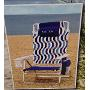

MLB713077319 - Cadeira De Praia Nautica Com Bolsa Térmica
http://produto.mercadolivre.com.br/MLB-713077319-cadeira-de-praia-nautica-com-bolsa-termica-_JM
473 unidades vendidas.
Faturamento de R$ 118202.7.
Adicionado há 401 dias.



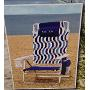

MLB706913814 - Cadeira De  Praia Dobravel Aluminio Nautica
http://produto.mercadolivre.com.br/MLB-706913814-cadeira-de-praia-dobravel-aluminio-nautica-_JM
296 unidades vendidas.
Faturamento de R$ 49429.04.
Adicionado há 422 dias.



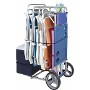

MLB719216291 - Carrinho De Praia 5 Cadeiras Com Avanço P/ Caixa Térmica Mor
http://produto.mercadolivre.com.br/MLB-719216291-carrinho-de-praia-5-cadeiras-com-avanco-p-caixa-termica-mor-_JM
282 unidades vendidas.
Faturamento de R$ 39169.8.
Adicionado há 380 dias.



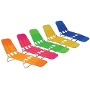

MLB699875265 - Kit C/ 03 Cadeiras Espreguiçadeira Praia Piscina Dobrável
http://produto.mercadolivre.com.br/MLB-699875265-kit-c-03-cadeiras-espreguicadeira-praia-piscina-dobravel-_JM
104 unidades vendidas.
Faturamento de R$ 35349.6.
Adicionado há 439 dias.



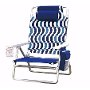

MLB704723545 - Cadeira De Praia Náutica Bolsa Térmica 5 Posições
http://produto.mercadolivre.com.br/MLB-704723545-cadeira-de-praia-nautica-bolsa-termica-5-posicoes-_JM
154 unidades vendidas.
Faturamento de R$ 33875.38.
Adicionado há 428 dias.



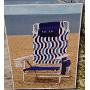

MLB717472958 - Cadeira Praia Nautika Essex
http://produto.mercadolivre.com.br/MLB-717472958-cadeira-praia-nautika-essex-_JM
162 unidades vendidas.
Faturamento de R$ 30614.76.
Adicionado há 386 dias.



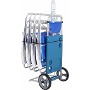

MLB716030273 - Carrinho De Praia E Mesa Em Alumínio P/ Até 5 Cadeiras - Mor
http://produto.mercadolivre.com.br/MLB-716030273-carrinho-de-praia-e-mesa-em-aluminio-p-ate-5-cadeiras-mor-_JM
295 unidades vendidas.
Faturamento de R$ 28880.5.
Adicionado há 391 dias.



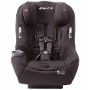

MLB760328191 - Maxi Cosi Pria 85 Cadeirinha De Carro Preta - Frete Gratis
http://produto.mercadolivre.com.br/MLB-760328191-maxi-cosi-pria-85-cadeirinha-de-carro-preta-frete-gratis-_JM
9 unidades vendidas.
Faturamento de R$ 25641.0.
Adicionado há 203 dias.



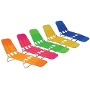

MLB699871216 - Kit C/ 02 Cadeiras Espreguiçadeira Praia Piscina Dobrável
http://produto.mercadolivre.com.br/MLB-699871216-kit-c-02-cadeiras-espreguicadeira-praia-piscina-dobravel-_JM
94 unidades vendidas.
Faturamento de R$ 21610.6.
Adicionado há 439 dias.



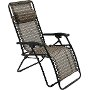

MLB682414049 - Cadeira Sevilha Reclinável, Praia, Piscina, 21 Posições Mor
http://produto.mercadolivre.com.br/MLB-682414049-cadeira-sevilha-reclinavel-praia-piscina-21-posicoes-mor-_JM
104 unidades vendidas.
Faturamento de R$ 20789.6.
Adicionado há 482 dias.



In [8]:
# prints URLs from itens sorting by revenue

df = df.sort_values('revenue', ascending=False)

print('Os ' + str(ITEMS_TO_PLOT) + ' itens com maior faturamento:', '\n')
for index, row in df.head(ITEMS_TO_PLOT).iterrows():
    display(Image(df.loc[index, 'thumbnail']))
    print(index + ' - ' + df.loc[index, 'title']) # uses loc taking advantage of indexing by id made previously
    print(df.loc[index, 'permalink'])
    print(str(df.loc[index, 'sold_quantity']) + ' unidades vendidas.')
    print('Faturamento de R$ ' + str(df.loc[index, 'revenue']) + '.')
    print('Adicionado há ' + str(df.loc[index, 'days_ago']) + ' dias.')
    print()

## Faturamento por item

O faturamento total ("cadeira de praia") = R$ 1080435.78


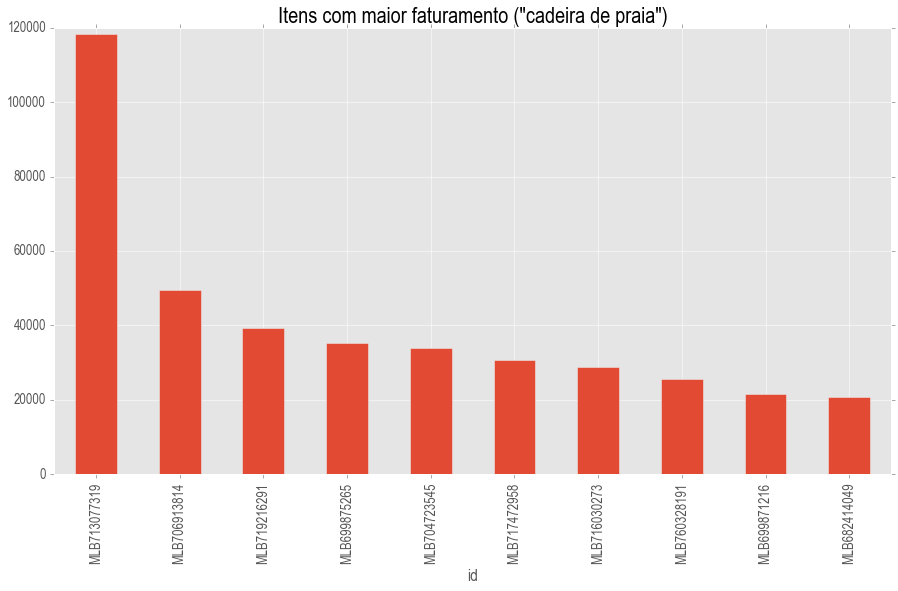

In [9]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))
df['revenue'].sort_values(ascending=False).head(ITEMS_TO_PLOT).plot(kind='bar')
plt.title('Itens com maior faturamento ("' + query + '")', fontsize=22)

## Quantidade vendida e preços

Total de unidades vendidas ("cadeira de praia") = 8096


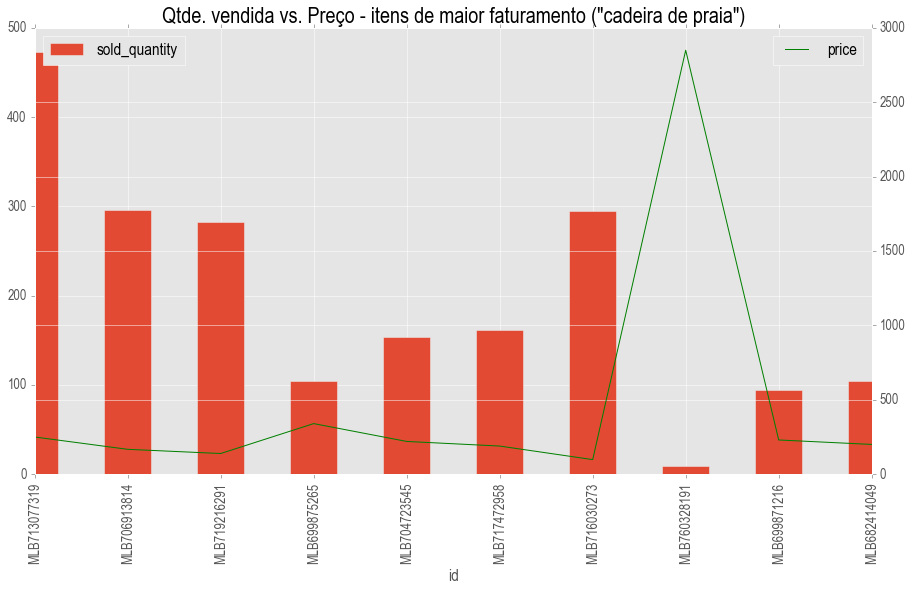

In [10]:
# sold quantity vs. unit price

print('Total de unidades vendidas ("' + query + '") = ' + str(total_sold_quantity))

# procedure to handle secondary Y axis
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()

y0 = df.head(ITEMS_TO_PLOT).sold_quantity.plot(kind='bar', ax=ax0)#, label='Itens vendidos')
y1 = df.head(ITEMS_TO_PLOT).price.plot(secondary_y=True, style='g', ax=ax1)#, label='Preço unitário')
y0.legend(loc=2) # bar legend to the left
y1.legend(loc=0) # line legend to the right

plt.title('Qtde. vendida vs. Preço - itens de maior faturamento ("' + query + '")', fontsize=22)
plt.show()
plt.close()

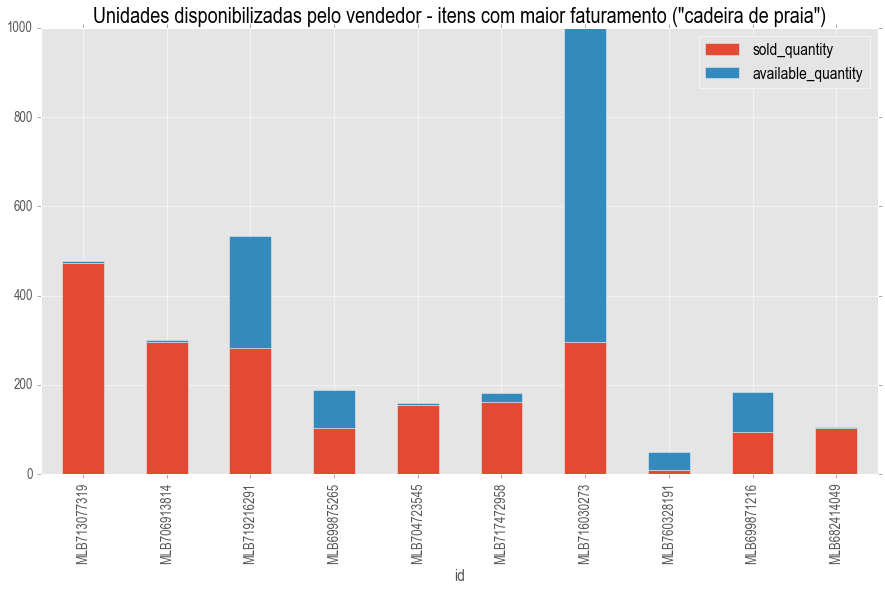

In [11]:
# total amount of each item (sold + stock)

df[['sold_quantity', 'available_quantity']].head(ITEMS_TO_PLOT).plot(kind='bar', stacked=True)
plt.title('Unidades disponibilizadas pelo vendedor - itens com maior faturamento ("' + query + '")', fontsize=22)

## Análise por cidade e estado (qtde. de anúncios e faturamento)

In [12]:
# location and stuff...

df2 = df # creates copy to play with

# extracting info from json/dict objects in cells

cities = [] # empty list to hold city names
states = [] # empty list to hold state names
sellers =[] # empty list to hold sellers ids

for index, row in df2.iterrows():
    cities.append(row['seller_address']['city']['name'])    
    states.append(row['seller_address']['state']['name'])    
    sellers.append(row['seller']['id'])    

df2['city'] = cities
df2['state'] = states
df2['seller_id'] = sellers
df2.head()

,title,price,sold_quantity,available_quantity,permalink,thumbnail,seller_address,seller,stop_time,revenue,start_time,days_ago,city,state,seller_id
id,,,,,,,,,,,,,,,
MLB713077319,Cadeira De Praia Nautica Com Bolsa Térmica,249.90,473,4,http://produto.mercadolivre.com.br/MLB-7130773...,http://mlb-s1-p.mlstatic.com/285601-MLB2035172...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-10-08 16:38:12,118202.70,2015-10-08 16:38:12,401,São Bernardo do Campo,São Paulo,80008507
MLB706913814,Cadeira De Praia Dobravel Aluminio Nautica,166.99,296,5,http://produto.mercadolivre.com.br/MLB-7069138...,http://mlb-s1-p.mlstatic.com/653601-MLB2034774...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-09-17 22:33:39,49429.04,2015-09-17 22:33:39,422,São Paulo,São Paulo,18665979
MLB719216291,Carrinho De Praia 5 Cadeiras Com Avanço P/ Cai...,138.90,282,251,http://produto.mercadolivre.com.br/MLB-7192162...,http://mlb-s1-p.mlstatic.com/187701-MLB2040519...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-10-29 11:02:13,39169.80,2015-10-29 11:02:13,380,Santa Cruz do Sul,Rio Grande do Sul,184417944
MLB699875265,Kit C/ 03 Cadeiras Espreguiçadeira Praia Pisci...,339.90,104,84,http://produto.mercadolivre.com.br/MLB-6998752...,http://mlb-s2-p.mlstatic.com/287001-MLB2025834...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-08-31 12:04:21,35349.60,2015-08-31 12:04:21,439,Itu,São Paulo,26684182
MLB704723545,Cadeira De Praia Náutica Bolsa Térmica 5 Posições,219.97,154,6,http://produto.mercadolivre.com.br/MLB-7047235...,http://mlb-s2-p.mlstatic.com/494311-MLB2054771...,"{'comment': '', 'country': {'name': 'Brasil', ...","{'real_estate_agency': False, 'tags': [], 'pow...",2035-09-11 03:15:54,33875.38,2015-09-11 03:15:54,428,Brasília,Distrito Federal,80615553


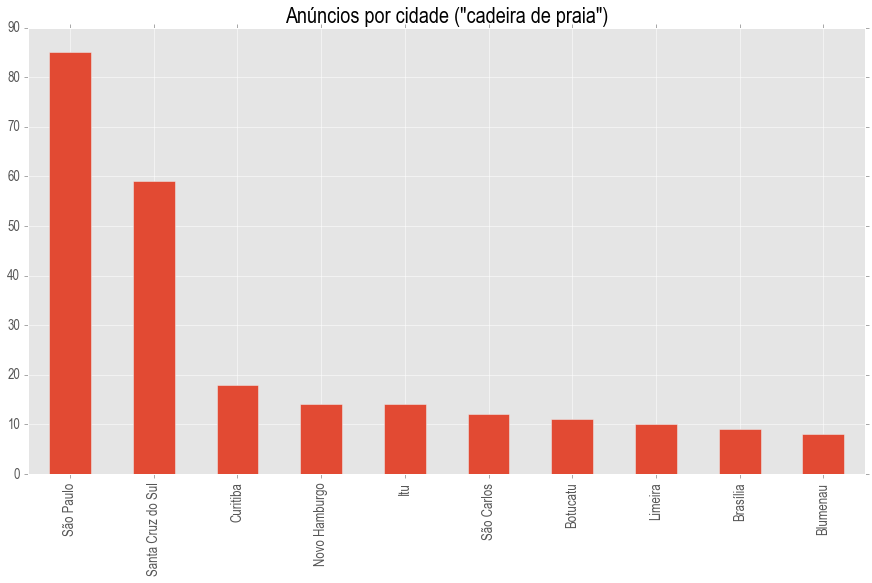

In [13]:
# plots itens by cities

df2.city.value_counts().head(10).plot(kind='bar')
plt.title('Anúncios por cidade ("' + query + '")', fontsize=22)

O faturamento total ("cadeira de praia") = R$ 1080435.78


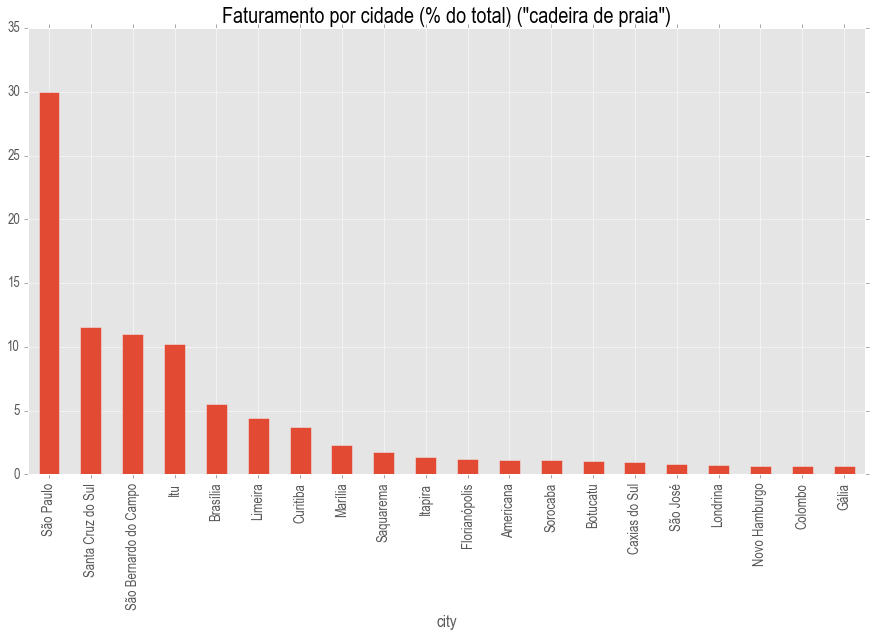

In [14]:
# revenue per city
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

revenue_share_by_city = (df2.groupby('city').sum().revenue / total_revenue) * 100 # aggregates data by city, sums by revenue and gets proportion from total
revenue_share_by_city.sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Faturamento por cidade (% do total) ("' + query + '")', fontsize=22)

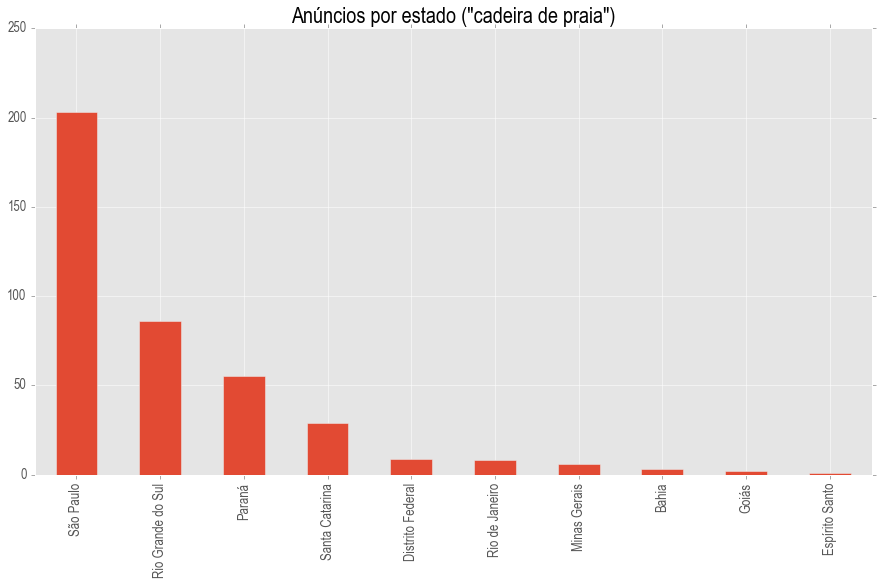

In [15]:
# plots itens by states
df2.state.value_counts().head(10).plot(kind='bar')
plt.title('Anúncios por estado ("' + query + '")', fontsize=22)

O faturamento total ("cadeira de praia") = R$ 1080435.78


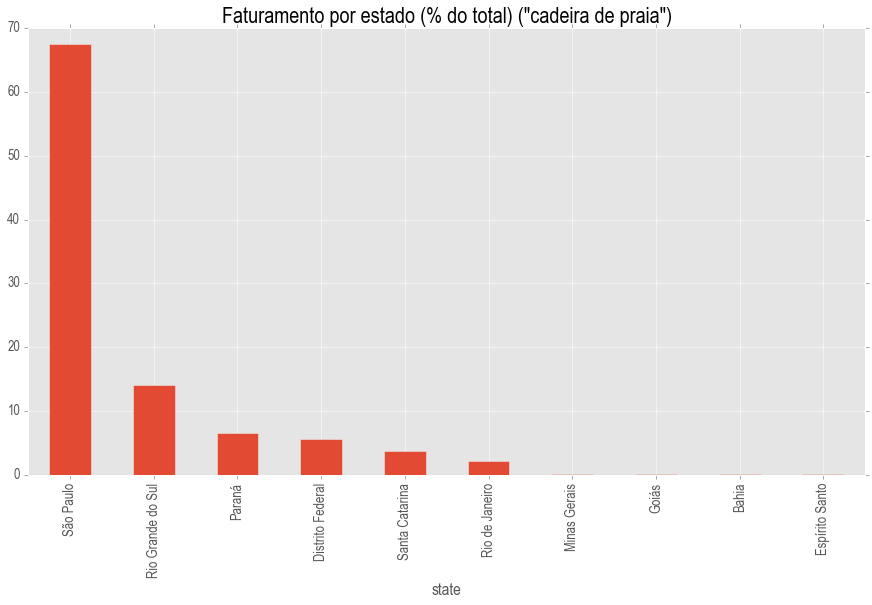

In [16]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

revenue_share_by_state = (df2.groupby('state').sum().revenue / total_revenue) * 100
revenue_share_by_state.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Faturamento por estado (% do total) ("' + query + '")', fontsize=22)

## Análise por vendedores

In [17]:
sellers_df = df2.groupby('seller_id').sum() # aggregates by sellers id, summing up the columns
sellers_df.price = df2.groupby('seller_id').mean().price # substitutes sum of prices by mean price by seller
sellers_df = sellers_df.rename(columns={'price': 'average_price'})
sellers_df.sort_values('revenue', ascending=False).head()

,average_price,sold_quantity,available_quantity,revenue,days_ago
seller_id,,,,,
80008507,249.900000,473,4,118202.70,401
26684182,199.085714,499,329,110826.90,5046
184417944,84.094444,966,15908,93885.80,6754
190434051,134.389000,429,123,54816.29,6010
18665979,232.495000,300,6,50621.04,829


O faturamento total ("cadeira de praia") = R$ 1080435.78


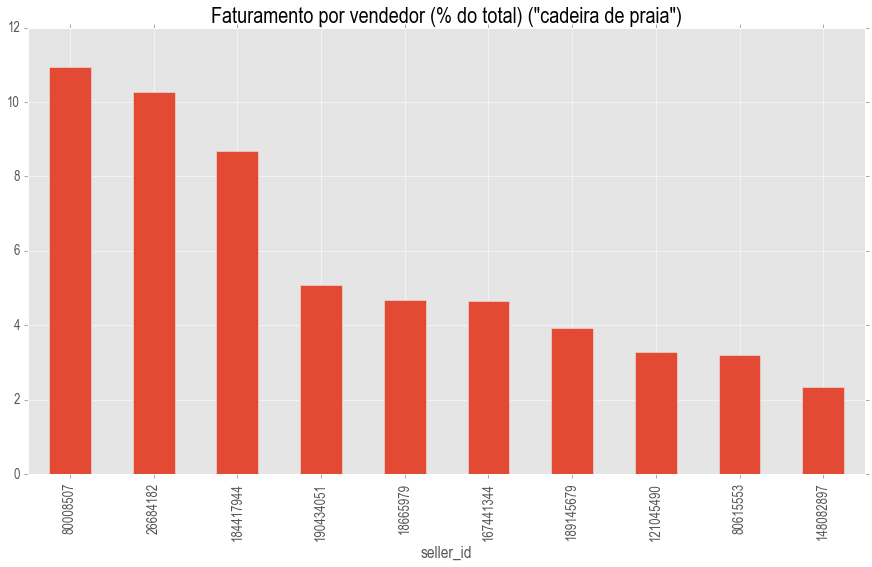

In [18]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

sellers_df = sellers_df.sort_values('revenue', ascending=False)
#sellers_df.revenue.sort_values(ascending=False).head(20).plot(kind='bar')

revenue_share_by_seller = (sellers_df['revenue'] / total_revenue) * 100
revenue_share_by_seller.head(10).plot(kind='bar')
plt.title('Faturamento por vendedor (% do total) ("' + query + '")', fontsize=22)
#sellers_df.head()

### Vendedor e itens como índices
Verificar como operar e se é útil de alguma forma...

In [19]:
# groups sellers and items, and then ...?
s = df2.reset_index()
s = s.groupby(['seller_id', 'id', 'permalink']).sum() # aggregates data by id and permalink to "save" them from being hidden

# sets id and permalink to be data in df
s = s.reset_index('id')
s = s.reset_index('permalink')

#reorder columns to make it readable
s = s[['id', 'sold_quantity', 'price', 'revenue', 'available_quantity', 'permalink']] 

s.head(10)

,id,sold_quantity,price,revenue,available_quantity,permalink
seller_id,,,,,,
470685,MLB705309612,3,93.0,279.0,3,http://produto.mercadolivre.com.br/MLB-7053096...
470685,MLB706674002,6,103.0,618.0,1,http://produto.mercadolivre.com.br/MLB-7066740...
470685,MLB707242311,7,197.0,1379.0,2,http://produto.mercadolivre.com.br/MLB-7072423...
470685,MLB715733718,10,103.0,1030.0,1,http://produto.mercadolivre.com.br/MLB-7157337...
470685,MLB715733721,8,77.0,616.0,1,http://produto.mercadolivre.com.br/MLB-7157337...
470685,MLB731696403,3,103.0,309.0,1,http://produto.mercadolivre.com.br/MLB-7316964...
470685,MLB732073354,63,49.9,3143.7,1,http://produto.mercadolivre.com.br/MLB-7320733...
470685,MLB732080903,12,78.0,936.0,3,http://produto.mercadolivre.com.br/MLB-7320809...
470685,MLB736596534,18,103.0,1854.0,8,http://produto.mercadolivre.com.br/MLB-7365965...


## Análise da data de anúncio dos itens (recenticidade)

In [20]:
# plot by days_ago (by date as the following charts is nicer)
#_range = (0, 30)
#df.days_ago.hist(range=_range, bins=30)
#plt.title('Distribuição de itens adicionados nos últimos 30 dias (dias atrás) ("' + query + '")', fontsize=22)

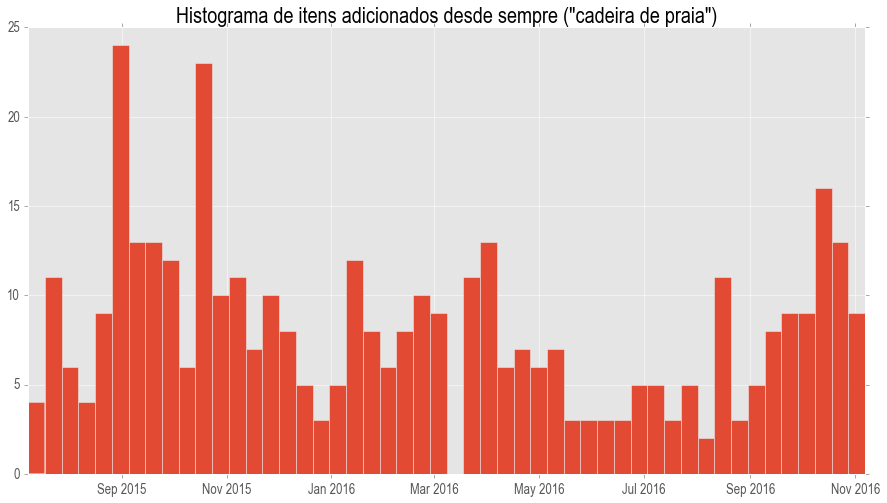

In [21]:
s = df

s.start_time.hist(bins=50)
plt.title('Histograma de itens adicionados desde sempre ("' + query + '")', fontsize=22)

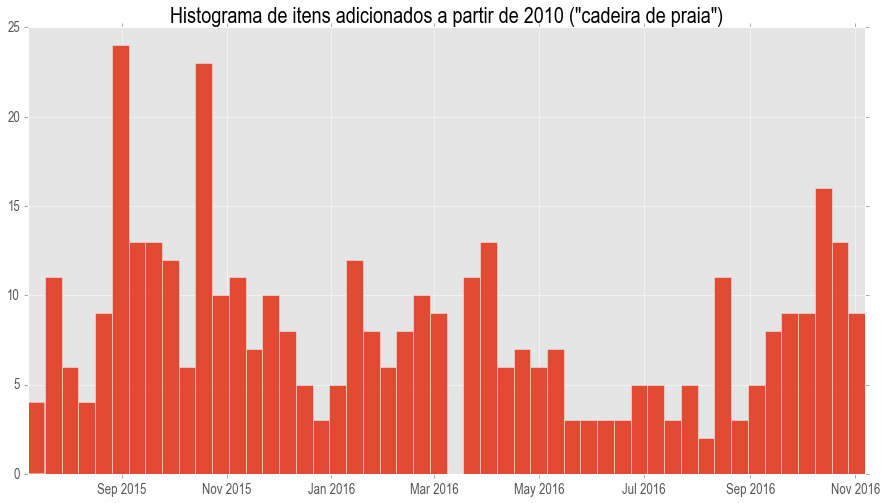

In [22]:
s = df[(df.start_time > '2010-01-01')] # filter dates later than 2010

s.start_time.hist(bins=50)
plt.title('Histograma de itens adicionados a partir de 2010 ("' + query + '")', fontsize=22)

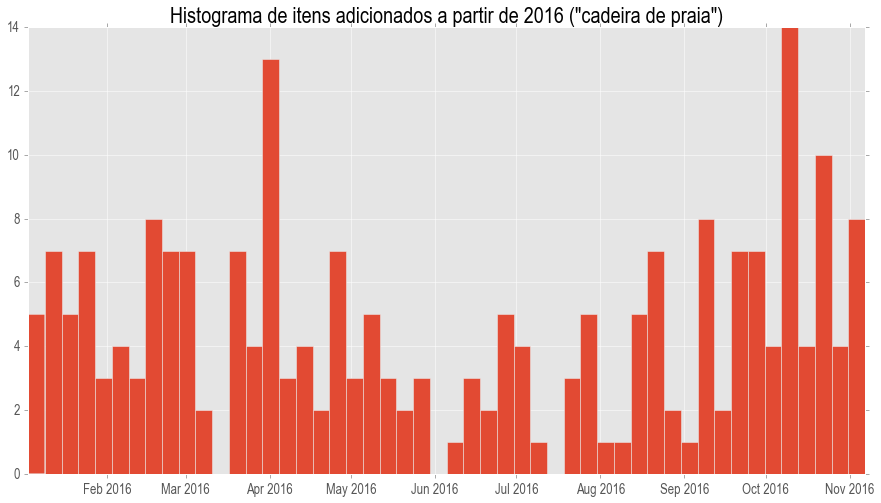

In [23]:
s = df[(df.start_time > '2016-01-01')] # filter dates later than 2016

s.start_time.hist(bins=50)
plt.title('Histograma de itens adicionados a partir de 2016 ("' + query + '")', fontsize=22)

Os 10 itens mais recentes: 



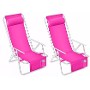

MLB811774258 - 2 Cadeiras De Praia Sol Verão Reclinável 7 Posições - Rosa
http://produto.mercadolivre.com.br/MLB-811774258-2-cadeiras-de-praia-sol-vero-reclinavel-7-posicoes-rosa-_JM
Adicionado há 6 dias.
0 unidade(s) já vendida(s).



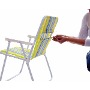

MLB811659327 - Refil Pano Para Cadeira De Praia Com 02 Unidades Fácil Troca
http://produto.mercadolivre.com.br/MLB-811659327-refil-pano-para-cadeira-de-praia-com-02-unidades-facil-troca-_JM
Adicionado há 6 dias.
1 unidade(s) já vendida(s).



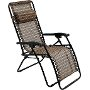

MLB811782722 - Cadeira Reclinável Praia Piscina Sevilha - Mor
http://produto.mercadolivre.com.br/MLB-811782722-cadeira-reclinavel-praia-piscina-sevilha-mor-_JM
Adicionado há 6 dias.
1 unidade(s) já vendida(s).



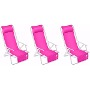

MLB811605694 - Kit 3 Cadeiras Praia Sol Verão Reclinável 7 Posições - Rosa
http://produto.mercadolivre.com.br/MLB-811605694-kit-3-cadeiras-praia-sol-vero-reclinavel-7-posicoes-rosa-_JM
Adicionado há 7 dias.
1 unidade(s) já vendida(s).



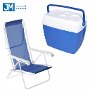

MLB810938242 - Cadeiras Praia Reclinável Aço 8p 1pç C/ Caixa Térmica Mor
http://produto.mercadolivre.com.br/MLB-810938242-cadeiras-praia-reclinavel-aco-8p-1pc-c-caixa-termica-mor-_JM
Adicionado há 8 dias.
0 unidade(s) já vendida(s).



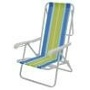

MLB801515826 - Cadeira De Praia Mor Reclinável Aço 8 Posições
http://produto.mercadolivre.com.br/MLB-801515826-cadeira-de-praia-mor-reclinavel-aco-8-posicoes-_JM
Adicionado há 9 dias.
12 unidade(s) já vendida(s).



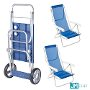

MLB810054957 - Carrinho De Praia C/ 2 Cadeiras Alumínio 8 Posições Mor
http://produto.mercadolivre.com.br/MLB-810054957-carrinho-de-praia-c-2-cadeiras-aluminio-8-posicoes-mor-_JM
Adicionado há 11 dias.
2 unidade(s) já vendida(s).



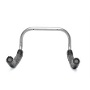

MLB700434578 - Suporte Parede Cadeiras De Praia - 100% Alumínio
http://produto.mercadolivre.com.br/MLB-700434578-suporte-parede-cadeiras-de-praia-100-aluminio-_JM
Adicionado há 11 dias.
72 unidade(s) já vendida(s).



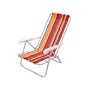

MLB749445332 - Cadeira De Praia Aço Mor  4 Posições !!!!
http://produto.mercadolivre.com.br/MLB-749445332-cadeira-de-praia-aco-mor-4-posicoes--_JM
Adicionado há 15 dias.
5 unidade(s) já vendida(s).



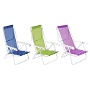

MLB808259884 - Cadeira De Praia Reclinável Aço 8 Posições Sannet Mor
http://produto.mercadolivre.com.br/MLB-808259884-cadeira-de-praia-reclinavel-aco-8-posicoes-sannet-mor-_JM
Adicionado há 18 dias.
0 unidade(s) já vendida(s).



In [24]:
print('Os ' + str(ITEMS_TO_PLOT) + ' itens mais recentes:', '\n')

recent_itens_df = df.sort_values('days_ago', ascending=True)

for index, row in recent_itens_df.head(ITEMS_TO_PLOT).iterrows():
    display(Image(df.loc[index, 'thumbnail'])) 
    print(index + ' - ' + df.loc[index, 'title']) # uses loc taking advantage of indexing by id made previously
    print(df.loc[index, 'permalink'])
    print('Adicionado há ' + str(df.loc[index, 'days_ago']) + ' dias.')
    print(str(df.loc[index, 'sold_quantity']) + ' unidade(s) já vendida(s).')
    print()

    

---
## Request por visitas dos itens filtrados e ordenados

- Itens com maior faturamento
- Itens mais vendidos
- Itens mais recentes

### Função para gerar DataFrame de visitas

In [25]:
def get_visits_df(days, ids):
    
    ids_string = ','.join(ids) # makes comma-separated string from list to use in URL

    url = 'https://api.mercadolibre.com/items/visits/time_window?ids=' + ids_string +'&last=' + str(days) + '&unit=day'
    data = requests.get(url).json()

    visits_df = DataFrame(data[0]['results']) # initialize a df with the first item out of 10 (top ten in ids_string)
    visits_df = visits_df[['date', 'total']] # gets only main columns
    visits_df.columns = ['date', data[0]['item_id']] # renames 'total' to item's ID

    column_headers = [] # list to store item ids used as column headers
    column_headers.append(data[0]['item_id'])

    # iterates over data items to merge all 'total' columns into same df
    for item in data[1:]:
        results = item['results']
        df_temp = DataFrame(results)
        df_temp = df_temp[['date', 'total']]
        df_temp.columns = ['date', item['item_id']]
        column_headers.append(item['item_id'])
        visits_df = pd.merge(visits_df, df_temp, on='date')

    #print(column_headers)
    #visits_df.head()

    # fixes df, parsing 'date' properly and setting as index column
    visits_df['date'] = pd.to_datetime(visits_df['date'])
    visits_df = visits_df.set_index('date')

    #visits_df.head()
    return visits_df

### Visitas aos itens com maior faturamento

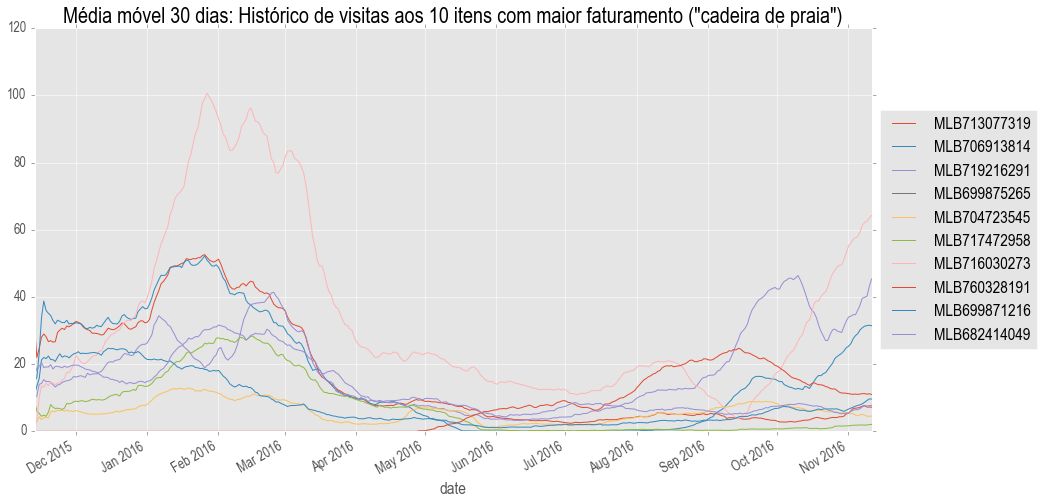

In [26]:
# defines ids from top revenue itens
top_revenue_ids = df.sort_values('revenue', ascending=False).index.values[0:ITEMS_TO_PLOT]

# get df by calling function with top sold ids
visits_df = get_visits_df(DAYS_AGO, top_revenue_ids)

# calculates and plots visits' rolling mean (smoother curves)
days_rolling = 30;
rolling_mean_df = visits_df.rolling(window=days_rolling, min_periods=1).mean() # window is the # of days evaluated in rolling mean
ax = rolling_mean_df.plot();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # moves legend to the right outside
plt.title('Média móvel ' + str(days_rolling) + ' dias: Histórico de visitas aos ' + str(ITEMS_TO_PLOT) + ' itens com maior faturamento ("' + query + '")', fontsize=22)

most_revenue_visits_df = visits_df # saves to a uniquely named df to be exported later

### Visitas aos itens mais vendidos

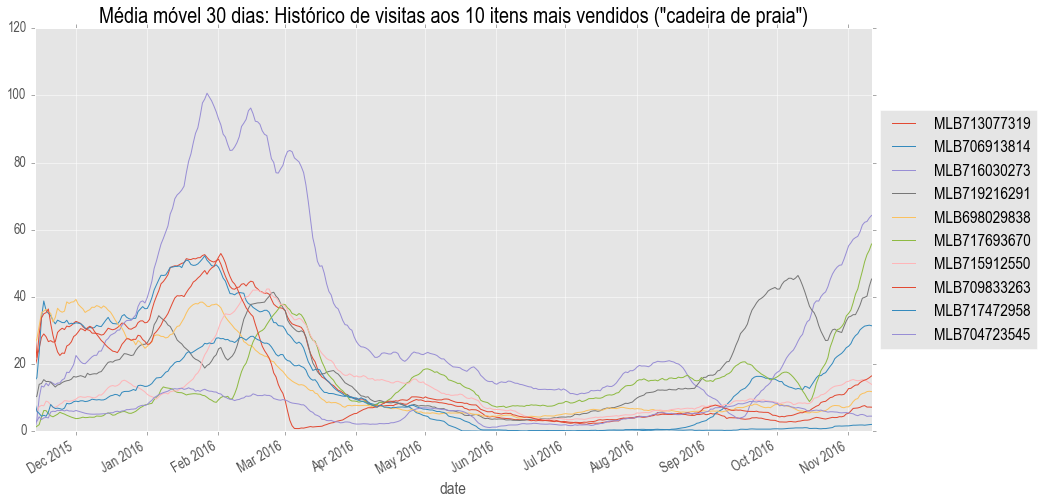

In [27]:
# defines ids from top sold itens
top_sold_ids = df.sort_values('sold_quantity', ascending=False).index.values[0:ITEMS_TO_PLOT]

# get df by calling function with top sold ids
visits_df = get_visits_df(DAYS_AGO, top_sold_ids)

# calculates and plots visits' rolling mean (smoother curves)
days_rolling = 30;
rolling_mean_df = visits_df.rolling(window=days_rolling, min_periods=1).mean() # window is the # of days evaluated in rolling mean
ax = rolling_mean_df.plot();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # moves legend to the right outside
plt.title('Média móvel ' + str(days_rolling) + ' dias: Histórico de visitas aos ' + str(ITEMS_TO_PLOT) + ' itens mais vendidos ("' + query + '")', fontsize=22)

most_sold_visits_df = visits_df # saves to a uniquely named df to be exported later

### Visitas aos itens mais recentes

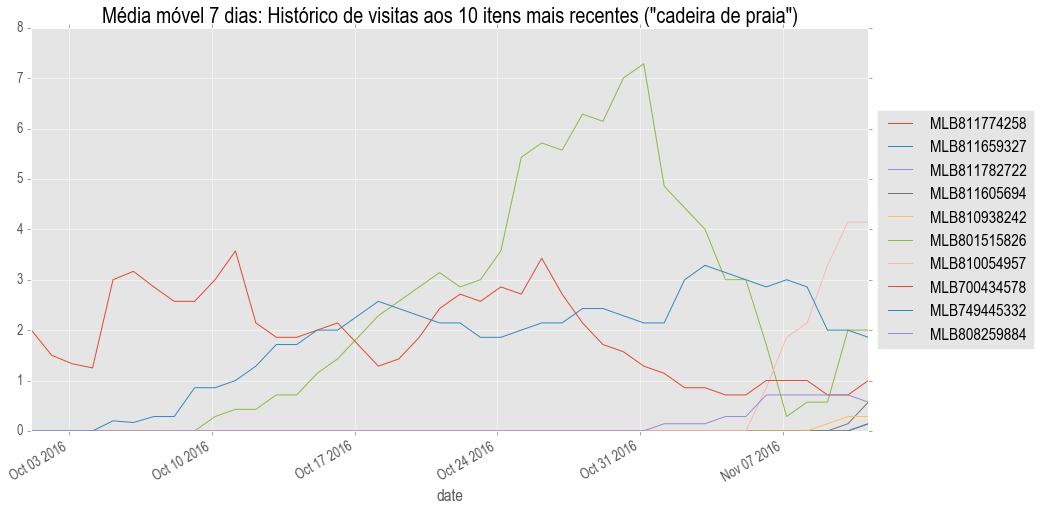

In [28]:
# gets ids from most recent itens
recent_ids = recent_itens_df.index.values[0:ITEMS_TO_PLOT] # gets most recent items ML ids in a list

# get df by calling function with most recent ids
visits_df = get_visits_df(DAYS_AGO, recent_ids)
visits_df = visits_df['2016-10-01':] # filters by some date (e.g. 1st of january, 2016)

# calculates and plots visits' rolling mean (smoother curves)
days_rolling = 7;
rolling_mean_df = visits_df.rolling(window=days_rolling, min_periods=1).mean() # window is the # of days evaluated in rolling mean
ax = rolling_mean_df.plot();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # moves legend to the right outside
plt.title('Média móvel ' + str(days_rolling) + ' dias: Histórico de visitas aos ' + str(ITEMS_TO_PLOT) + ' itens mais recentes ("' + query + '")', fontsize=22)

most_recent_visits_df = visits_df # saves to a uniquely named df to be exported later

In [29]:
# normal plot
#plt.figure()
#visits_df.plot(legend=True);
#plt.title('Histórico de visitas aos 10 itens mais vendidos ("' + query + '")', fontsize=22)

# cumulative sum plot
#cumulative_visits_df = visits_df.cumsum() # calculates accumulated values to plot
#plt.figure();
#cumulative_visits_df.plot(legend=True);
#plt.title('Soma acumulada: Histórico de visitas aos 10 itens mais vendidos ("' + query + '")', fontsize=22)

## Exporta dados para Excel
Salva os principais DataFrames em diferentes abas de um arquivo .xlsx e salva na pasta raiz.

In [30]:
# saves main df to Excel format
today_str = today.strftime('%Y-%m-%d_%H%M') # makes string with today's date

writer = pd.ExcelWriter(today_str + '_' + query + '.xlsx')

df.to_excel(writer, 'main_data')
sellers_df.to_excel(writer, 'sellers')
most_revenue_visits_df.to_excel(writer, 'visits-revenue_sold')
most_sold_visits_df.to_excel(writer, 'visits-most_sold')
most_recent_visits_df.to_excel(writer, 'visits-most_recent')

writer.save()
writer.close()

## Todo:
**Features**
- Plot itens by seller location (map?)
- <s>Calculate revenue per seller (extract from seller dict in raw df)</s>
- <s>Understand data aggregated by SELLER, not only by separate items</s>
- Get location of the BUYERS, not only sellers
- Compare seller revenue with its ratings/feedbacks
- <s>Analyse itens by date and recently added itens</s>
- <s>Play around with 'added_days_ago' and 'sold_quantity' = how appealing the product is</s>
- Filter by minimum item price
---
**Code improvement**
- Fix query handling for 0 results
- Fix query handling for null query as input
- Fix documentation/description
- Make dates relative to today's (e.g. instead of '2016', get the year from datetime 'today')
---
**Usability**
- Add an index for jumping to parts (links for navigation)